In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.21 GB
Available RAM  : 26.63 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ""#"sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Cleaning dataset Melanogaster_RL/Z..	:   0%|          | 0/774 [00:00<?, ?it/s]

Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']


Cleaning dataset Melanogaster_RL/Z..	: 100%|██████████| 774/774 [01:22<00:00,  9.43it/s]


Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 7889 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


In [5]:
transformed_dataset = ConcatDataset([dmel1, dsuz1])
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

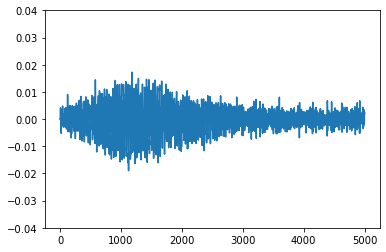

In [6]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [7]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'conv1draw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)
# print(model)

In [8]:
# list(model.children())[0]

In [9]:
# test if everything works with mock input
# import torchsummary
# torchsummary.summary(model, (1,10000))
# x = torch.randn(32, 1, 5000)

# output = model(x)
# output

## Training

In [10]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 90.49it/s] 


Validation loss decreased (inf --> 0.582017).  Saving model ...


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 0: train_acc: 86.99% loss: 0.087,  val_loss: 0.582 val_acc: 51.10%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 1: train_acc: 90.79% loss: 0.141,  val_loss: 0.817 val_acc: 41.58%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 2: train_acc: 91.61% loss: 0.105,  val_loss: 0.636 val_acc: 52.76%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 3: train_acc: 92.21% loss: 0.128,  val_loss: 1.884 val_acc: 41.20%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch 4: train_acc: 93.08% loss: 0.090,  val_loss: 2.101 val_acc: 40.08%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.582017 --> 0.064691).  Saving model ...
Epoch 5: train_acc: 94.90% loss: 0.045,  val_loss: 0.065 val_acc: 91.74%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 6: train_acc: 95.36% loss: 0.043,  val_loss: 0.194 val_acc: 86.43%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 7: train_acc: 95.73% loss: 0.034,  val_loss: 0.065 val_acc: 86.99%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 8: train_acc: 95.85% loss: 0.024,  val_loss: 0.198 val_acc: 81.30%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9: train_acc: 96.15% loss: 0.036,  val_loss: 0.278 val_acc: 72.91%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.064691 --> 0.030927).  Saving model ...
Epoch 10: train_acc: 96.58% loss: 0.022,  val_loss: 0.031 val_acc: 94.47%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.030927 --> 0.025179).  Saving model ...
Epoch 11: train_acc: 96.63% loss: 0.014,  val_loss: 0.025 val_acc: 94.77%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 12: train_acc: 96.65% loss: 0.030,  val_loss: 0.030 val_acc: 94.57%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.025179 --> 0.019625).  Saving model ...
Epoch 13: train_acc: 96.74% loss: 0.030,  val_loss: 0.020 val_acc: 94.82%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 14: train_acc: 96.77% loss: 0.022,  val_loss: 0.025 val_acc: 94.77%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 15: train_acc: 96.72% loss: 0.013,  val_loss: 0.022 val_acc: 94.69%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 16: train_acc: 96.79% loss: 0.024,  val_loss: 0.027 val_acc: 94.64%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17: train_acc: 96.83% loss: 0.018,  val_loss: 0.020 val_acc: 94.69%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 18: train_acc: 96.85% loss: 0.016,  val_loss: 0.020 val_acc: 94.72%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.019625 --> 0.018821).  Saving model ...
Epoch 19: train_acc: 96.84% loss: 0.024,  val_loss: 0.019 val_acc: 94.69%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.018821 --> 0.017988).  Saving model ...
Epoch 20: train_acc: 96.93% loss: 0.021,  val_loss: 0.018 val_acc: 94.72%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 21: train_acc: 96.84% loss: 0.022,  val_loss: 0.018 val_acc: 94.75%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 22: train_acc: 96.86% loss: 0.013,  val_loss: 0.019 val_acc: 94.75%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Validation loss decreased (0.017988 --> 0.017825).  Saving model ...
Epoch 23: train_acc: 96.94% loss: 0.018,  val_loss: 0.018 val_acc: 94.69%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 24: train_acc: 96.85% loss: 0.031,  val_loss: 0.018 val_acc: 94.67%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 25: train_acc: 96.92% loss: 0.017,  val_loss: 0.018 val_acc: 94.67%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 26: train_acc: 96.90% loss: 0.022,  val_loss: 0.019 val_acc: 94.70%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch    28: reducing learning rate of group 0 to 1.0000e-06.
Epoch 27: train_acc: 96.84% loss: 0.013,  val_loss: 0.018 val_acc: 94.70%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 28: train_acc: 96.92% loss: 0.019,  val_loss: 0.018 val_acc: 94.67%


Training..	:   0%|          | 0/755 [00:00<?, ?it/s]

Epoch 29: train_acc: 96.90% loss: 0.021,  val_loss: 0.018 val_acc: 94.67%


Validating..	: 100%|██████████| 95/95 [00:01<00:00, 87.75it/s] 

Early stopping


## Testing

### testing on datasets with same conditions

In [33]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [41]:
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, loader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)

In [42]:
test(model,test_dataloader)

Testing..	: 100%|██████████| 314/314 [00:02<00:00, 128.44it/s]

95.37718949044586


### testing on ALL available datasets (collected with the same sensor)

In [47]:
ds1 = WingbeatsDataset(dsname="Suzukii_RL/R", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds2 = WingbeatsDataset(dsname="Suzukii_RL/L", custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
ds3 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds4 = WingbeatsDataset(dsname="Melanogaster_RL/X", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
ds5 = WingbeatsDataset(dsname="Melanogaster_RL/W", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))

dslist = [ds1, ds2, ds3, ds4, ds5]#, dmel2, dsuz2]

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Found 10110 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14156 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


Testing..	:   0%|          | 0/587 [00:00<?, ?it/s]

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 407 in dataset: Melanogaster_RL/X, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 742 in dataset: Melanogaster_RL/W, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]


Testing..	: 100%|██████████| 587/587 [00:03<00:00, 147.18it/s]

88.37042163543441


In [50]:
dslist = [ds1, ds2, ds4, ds5]#, dmel2, dsuz2]

test_dataset = ConcatDataset(dslist)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

test(model,test_dataloader); del dslist

Testing..	: 100%|██████████| 398/398 [00:02<00:00, 138.61it/s]

84.4535175879397


In [25]:
@torch.no_grad()
def get_all_preds(model, loader):
#     model = model.to('cuda', dtype=torch.float)
    model.eval()

    results = {}
    results['preds'] = torch.tensor([])
    results['fnames'] = ()
    results['labels'] = torch.tensor([])
    results['idx'] = torch.tensor([])

    for x_batch,y_batch,path_batch,idx_batch in tqdm(loader):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)

        results['fnames'] += path_batch
        results['labels'] = torch.cat( (results['labels'], y_batch), dim=0)
        results['idx'] = torch.cat( (results['idx'], idx_batch), dim=0)

        preds = model(x_batch.float())
        results['preds'] = torch.cat(
            (results['preds'], preds)
            ,dim=0
        )
    return results
model = model.to('cpu', dtype=torch.float)
results = get_all_preds(model, test_dataloader)

def softmax_out(x):
    return np.argmax(F.softmax(x.reshape(1,-1), dim=1), axis=1).tolist()[0]

results['preds_labels'] = list(map(softmax_out, results['preds']))

100%|██████████| 587/587 [01:41<00:00,  5.78it/s]


In [26]:
df = pd.DataFrame(results)
df['humidity'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-1][:-4]).astype(float).values
df['temperature'] = df.fnames.apply(lambda x: x.split('/')[-1].split('_')[-3]).astype(float).values
df.sample(3)

,preds,fnames,labels,idx,preds_labels,humidity,temperature
21615,"(tensor(-1.5203), tensor(1.5613))",/home/kalfasyan/data/wingbeats/Suzukii_RL/L/D_20_08_18_13_32_37/F200818_133633_237_G_050_T_23.8_H_-4.5.wav,1.0,11505.0,1,-4.5,23.8
22026,"(tensor(-0.2977), tensor(0.3494))",/home/kalfasyan/data/wingbeats/Suzukii_RL/L/D_20_08_13_08_42_09/F200813_085956_029_G_050_T_24.5_H_2.3.wav,1.0,11916.0,1,2.3,24.5
22640,"(tensor(-1.0208), tensor(1.0345))",/home/kalfasyan/data/wingbeats/Suzukii_RL/L/D_20_08_22_15_39_42/F200822_164524_122_G_050_T_23.8_H_-0.1.wav,1.0,12530.0,1,-0.1,23.8


## Plotting

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
ticklabels = ['Melanogaster','Suzukii']

True vs Predicted


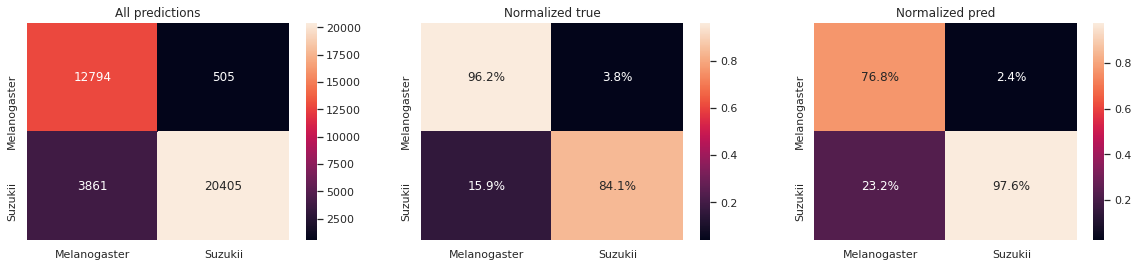

In [28]:
plt.figure(figsize=(20,4));
print("True vs Predicted")
plt.subplot(1,3,1); plt.title('All predictions');
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize=None)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,2); plt.title('Normalized true')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);
plt.subplot(1,3,3); plt.title('Normalized pred')
cm = confusion_matrix(y_true=df.labels.astype(int), y_pred=df.preds_labels, normalize='pred')
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=ticklabels, yticklabels=ticklabels);

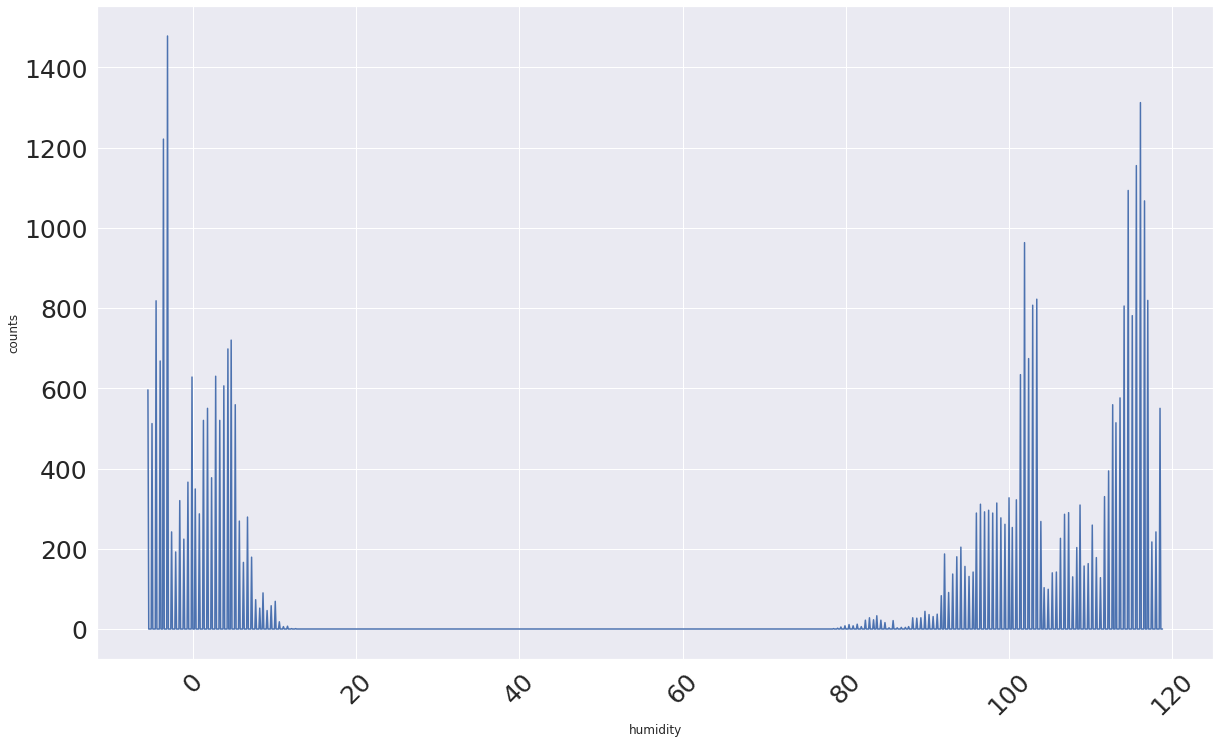

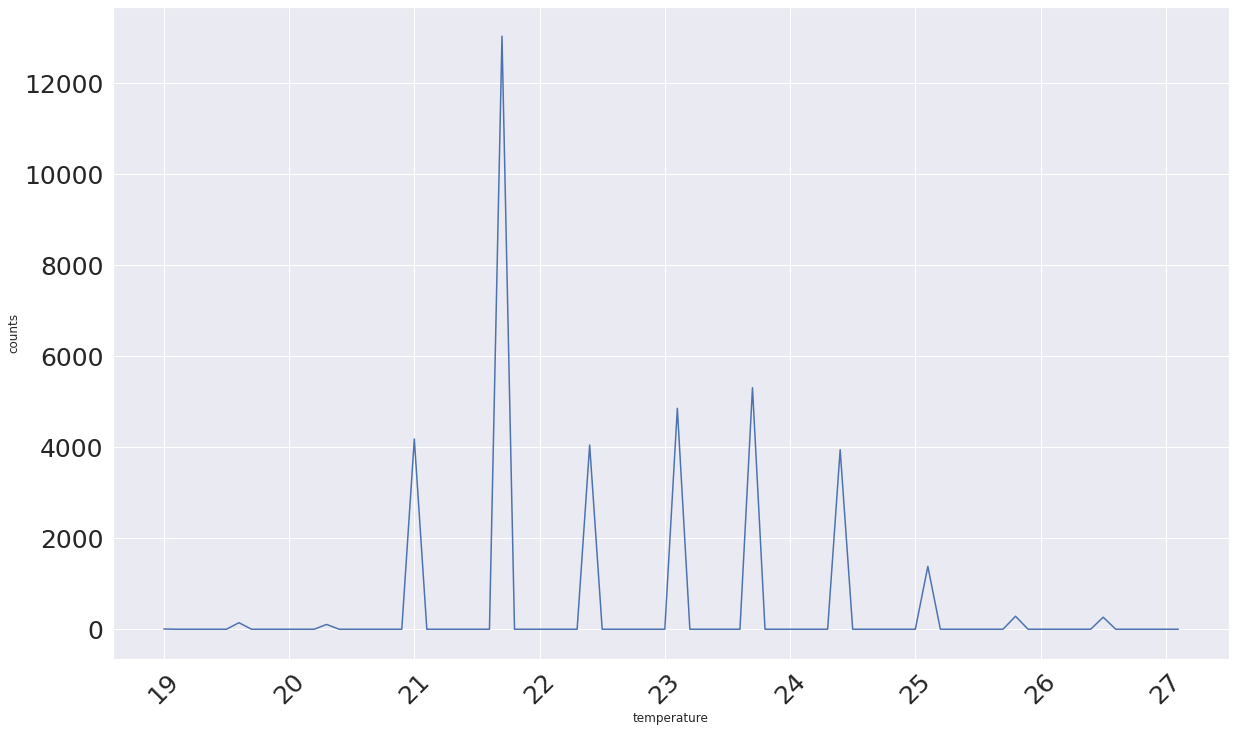

In [49]:
from utils import np_hist
plt.figure(figsize=(20,12))
np_hist(df, 'humidity', fs=25)
plt.figure(figsize=(20,12))
np_hist(df, 'temperature', fs=25)